# Prototype Dataset
This file generates the path-to-path dataset to train a prototype transformer

The input output sequence of a logo should consist of 270 Parameters
- DeepSVG Embedding (256)
- a0 Type "EOS" (1)
- a1 - a6 Type (6)
- a7 - a12 Param (6)
- a13 time offset from beginning of animation in seconds

Input Sequence
- In the input sequence, the last 13 Parameters are set to zero
- In a final model, these parameters are aimed to be left out (as context vector isn't based on that)

Output Sequence
- The Output sequence consists of the selected paths represented by their DeepSVG Embedding
- The Animation is represented through the type and the parameters.
- Each output sequence ends with an EOS Token, where the EOS-type in the one-hot-encoded part is set to 1.

## Import DeepSVG Embedding

In [1]:
import pickle

import torch

with open("data/embeddings/path_embedding.pkl", "rb") as f:
    deepsvg_embedding = pickle.load(f)

In [2]:
## duplicate for further use
embeddings = deepsvg_embedding.copy() #for output sequences
input_sequences = deepsvg_embedding

In [3]:
embeddings['animation_id'] = embeddings['animation_id'].astype(int)
embeddings.head()

,filename,animation_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,logo_0,1,0.851117,-1.775123,0.649689,-0.688600,0.216071,0.135211,-1.748761,-1.347670,...,-1.616431,-1.572003,0.242460,0.430259,0.079752,-1.039526,-0.696104,0.090277,-0.228757,0.144372
1,logo_0,0,0.763518,-0.982797,-0.446681,1.089468,-0.070563,0.710206,-0.491675,-1.631172,...,0.339061,0.022934,0.195161,-0.046488,-0.492103,-0.605836,-1.282879,0.613195,0.297194,-0.172312
2,logo_0,2,0.328628,-0.612160,1.592824,-0.422598,-0.765523,1.140459,0.145881,0.240300,...,-0.254159,-0.790789,-0.057158,1.594653,0.395605,-1.048015,0.454987,-0.439861,1.430237,0.192277
3,logo_0,3,0.291136,-0.928242,0.265542,-0.261439,-0.386160,1.256256,-0.414706,-1.206105,...,-0.446020,-1.369758,0.356421,1.456656,0.468766,-1.077724,-0.548627,-0.300660,0.632805,-0.136473
4,logo_0,4,0.504446,-0.543099,0.915062,1.293575,-0.849605,1.120387,-0.637641,-1.337280,...,0.162753,0.206993,-0.201259,-1.087391,-0.597388,-0.992079,-0.851486,-0.225463,-0.549269,0.088637


## Train / Test Split

### Logo Dataset Analysis
Most logos have only a few paths
Some logos have over 100 paths to animate

In [4]:
# Might not execute
# input_sequences['filename'].value_counts().hist(bins=100)

### Stratify on Number of Paths in Logo

In [5]:
# Count occurrences
logos = input_sequences.groupby('filename').size().reset_index(name='count')

# To stratify later, categorize the sizes
bins = 20
quantiles = [(i+1)/bins for i in range(bins)]
print(quantiles)

percentiles = logos['count'].quantile(quantiles)
print(percentiles)

# Function to categorize based on quantiles
def categorize_count(count):
    for i, percentile in enumerate(percentiles):
        if count <= percentile:
            return f"Quantile {i}"
    return f"Quantile {len(quantiles)}"

# Apply the categorization function to create a new column
logos['count_category'] = logos['count'].apply(categorize_count)
logos['count_category'].value_counts()

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
0.05      8.8
0.10     10.0
0.15     11.0
0.20     13.2
0.25     14.0
0.30     15.8
0.35     17.0
0.40     20.0
0.45     21.0
0.50     22.0
0.55     23.0
0.60     24.0
0.65     25.0
0.70     26.0
0.75     27.0
0.80     28.8
0.85     30.6
0.90     33.0
0.95     50.0
1.00    194.0
Name: count, dtype: float64


Quantile 1     36
Quantile 7     32
Quantile 10    30
Quantile 17    25
Quantile 6     23
Quantile 14    23
Quantile 4     23
Quantile 11    23
Quantile 16    22
Quantile 0     22
Quantile 8     21
Quantile 18    21
Quantile 13    20
Quantile 19    20
Quantile 5     20
Quantile 15    19
Quantile 3     18
Quantile 9     15
Quantile 12    12
Quantile 2     12
Name: count_category, dtype: int64

### Train / Test split

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and testing sets, stratifying on 'count_category'
logos_train, logos_test = train_test_split(logos, test_size=0.2, stratify=logos['count_category'], random_state=42)

The distributions of lenghts are now similar. Outliers with a long sequence are in both datasets

<AxesSubplot:>

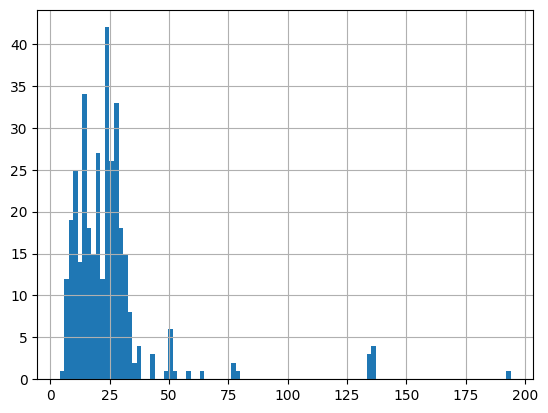

In [7]:
logos_train['count'].hist(bins=100)

<AxesSubplot:>

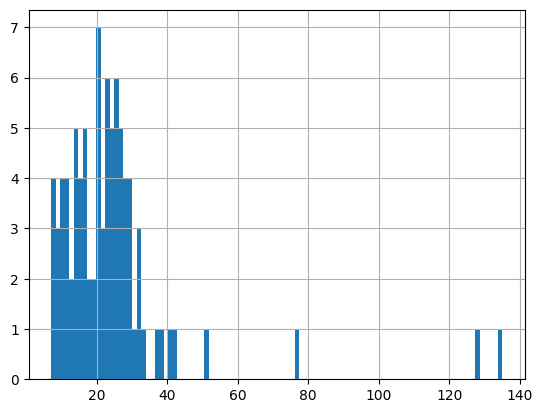

In [8]:
logos_test['count'].hist(bins=100)

In [9]:
logos_test = logos_test['filename'].unique()
logos_train = logos_train['filename'].unique()
logos_test

array(['logo_53', 'logo_178', 'logo_394', 'logo_194', 'logo_233',
       'logo_284', 'logo_100', 'logo_222', 'logo_93', 'logo_94',
       'logo_67', 'logo_336', 'logo_362', 'logo_364', 'logo_86',
       'logo_62', 'logo_245', 'logo_350', 'logo_275', 'logo_27',
       'logo_290', 'logo_175', 'logo_200', 'logo_331', 'logo_70',
       'logo_16', 'logo_65', 'logo_402', 'logo_390', 'logo_387',
       'logo_111', 'logo_320', 'logo_286', 'logo_6', 'logo_313',
       'logo_340', 'logo_118', 'logo_166', 'logo_269', 'logo_373',
       'logo_203', 'logo_221', 'logo_361', 'logo_363', 'logo_271',
       'logo_140', 'logo_190', 'logo_409', 'logo_145', 'logo_28',
       'logo_372', 'logo_112', 'logo_248', 'logo_280', 'logo_226',
       'logo_135', 'logo_294', 'logo_410', 'logo_267', 'logo_188',
       'logo_428', 'logo_399', 'logo_208', 'logo_232', 'logo_186',
       'logo_303', 'logo_21', 'logo_212', 'logo_348', 'logo_287',
       'logo_407', 'logo_405', 'logo_77', 'logo_408', 'logo_256',
       'lo

### Discussion
- One might also stratify over used animation types.
- Are there enough good animations in the dataset for logos with lots of paths? -> Manual annotation

## Animation Dataset

In [10]:
import pickle
import pandas as pd

# Load the pickle file
with open("data/surrogate_model/animation_label.pkl", "rb") as f:
    imported_pickle = pickle.load(f)

# Create a DataFrame from the imported data
filtered_data = pd.DataFrame(imported_pickle, columns=["file", "animation_id", "model_output", "label"])

# Define the mapping for ratings
mapping_dict = {"Very Good": 6, "Good": 5, "Okay": 4, "Bad": 3, "Very Bad": 2, "no_rating": 1}

# Replace the 'label' column with the corresponding ratings using .map
filtered_data['rating'] = filtered_data['label'].map(mapping_dict)

# Extract unique logos by splitting 'file' with "_animation" and using .str.get(0)
#logos_unique = filtered_data['file'].str.split('_animation').str.get(0).unique()

In [11]:
#example
filtered_data[filtered_data["file"].str.contains("logo_5_")]

,file,animation_id,model_output,label,rating
16940,logo_5_animation_0,7,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",NaN,NaN
16941,logo_5_animation_0,0,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.8...",NaN,NaN
16942,logo_5_animation_0,5,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",NaN,NaN
16943,logo_5_animation_1,7,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Bad,3.0
16944,logo_5_animation_2,7,"[1, 0, 0, 0, 0, 0, 0.9560342718892494, 0.94782...",Very Bad,2.0
16945,logo_5_animation_2,0,"[0, 0, 1, 0, 0, 0, -1.0, -1.0, -1.0, 0.0565513...",Very Bad,2.0
16946,logo_5_animation_3,7,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Bad,3.0
16947,logo_5_animation_3,0,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.2...",Okay,4.0
16948,logo_5_animation_3,4,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Very Bad,2.0
16949,logo_5_animation_4,7,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.2...",Good,5.0


### Consistency: Delete twice animated paths in one animation
Every animation should animate each path only once. **But there are duplicates.**
Some duplicates are completely equal.

In [12]:
# Example
filtered_data[filtered_data['file'] == "logo_379_animation_5"]

,file,animation_id,model_output,label,rating
13311,logo_379_animation_5,27,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Okay,4.0
13312,logo_379_animation_5,27,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Okay,4.0
13313,logo_379_animation_5,33,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0
13314,logo_379_animation_5,33,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Okay,4.0
13315,logo_379_animation_5,28,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.6...",Good,5.0
13316,logo_379_animation_5,28,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.6...",Okay,4.0
13317,logo_379_animation_5,31,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.7...",Okay,4.0
13318,logo_379_animation_5,31,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.7...",Okay,4.0
13319,logo_379_animation_5,32,"[0, 1, 0, 0, 0, 0, -1.0, -1.0, 0.7398985747399...",Good,5.0
13320,logo_379_animation_5,32,"[0, 1, 0, 0, 0, 0, -1.0, -1.0, 0.7398985747399...",Okay,4.0


In [13]:
# SIMPLE DUPLICATE REDUCTION
print(f"There are {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

# Create a copy for and convert numpy to strings
duplicate_search = filtered_data.copy()
duplicate_search['model_output'] = duplicate_search['model_output'].apply(lambda x: str(x))

# Find duplicates in the copy and remove with a mask
duplicates_mask = duplicate_search.duplicated(keep='first')
filtered_data = filtered_data[~duplicates_mask]

print(f"Reduced to {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

There are 243 duplicates.
Reduced to 124 duplicates.


But there are some more duplicates. Some have different ratings, so let's simply keep the better rating:

In [14]:
duplicates_mask = filtered_data.duplicated(subset=['file', 'animation_id'], keep=False)
filtered_data[duplicates_mask]

,file,animation_id,model_output,label,rating
1758,logo_159_animation_3,11,"[0, 1, 0, 0, 0, 0, -1.0, -1.0, 0.2379646270918...",Bad,3.0
1759,logo_159_animation_3,11,"[0, 1, 0, 0, 0, 0, -1.0, -1.0, 0.2379646270918...",Okay,4.0
1863,logo_181_animation_12,13,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.4...",Okay,4.0
1864,logo_181_animation_12,13,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.4...",Good,5.0
2417,logo_36_animation_12,0,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Bad,3.0
...,...,...,...,...,...
23352,logo_126_animation_3,34,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.2...",Good,5.0
23353,logo_126_animation_3,5,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0
23354,logo_126_animation_3,5,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Very Bad,2.0
23762,logo_91_animation_12,22,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.4...",Bad,3.0


In [15]:
# Sort the DataFrame by 'file', 'animation_id' (for grouping) and 'rating' (descending order to prioritize higher ratings)
filtered_data_sorted = filtered_data.sort_values(by=['file', 'animation_id', 'rating'], ascending=[True, True, False])

# Mark duplicates, keeping the row with the highest rating
duplicates_mask = filtered_data_sorted.duplicated(subset=['file', 'animation_id'], keep='first')

# Identify the indices of rows to keep and filter the original DataFrame
indices_to_keep = filtered_data_sorted[~duplicates_mask].index

filtered_data = filtered_data.loc[filtered_data.index.intersection(indices_to_keep)]

print(f"Reduced to {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

Reduced to 0 duplicates.


Now all duplicates are gone. Let's check with an example:

In [16]:
# Check: Should be 7 animations instead of 14 
filtered_data[filtered_data['file'] == "logo_379_animation_5"]  # EG: logo_379_animation_5 , logo_334_animation_12

,file,animation_id,model_output,label,rating
13311,logo_379_animation_5,27,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Okay,4.0
13313,logo_379_animation_5,33,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0
13315,logo_379_animation_5,28,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.6...",Good,5.0
13317,logo_379_animation_5,31,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.7...",Okay,4.0
13319,logo_379_animation_5,32,"[0, 1, 0, 0, 0, 0, -1.0, -1.0, 0.7398985747399...",Good,5.0
13322,logo_379_animation_5,30,"[0, 0, 1, 0, 0, 0, -1.0, -1.0, -1.0, 0.9223249...",Okay,4.0
13324,logo_379_animation_5,29,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Okay,4.0


In [17]:
filtered_data.reset_index(drop=True, inplace=True)

### Some Statistics about the Animations we have here
Result: Many animations with only one animated path

In [18]:
grouped = filtered_data.groupby('file').count()
grouped = grouped[['animation_id']]
print(f"{grouped.size} Animations initially")
histogram_table = grouped['animation_id'].value_counts().reset_index()
histogram_table.columns = ['Animation Length', 'Count']
histogram_table = histogram_table.sort_values(by='Animation Length')
print(histogram_table)

9907 Animations initially
   Animation Length  Count
1                 1   2901
0                 2   3175
2                 3   2301
3                 4    876
4                 5    312
5                 6    220
6                 7    112
7                 8     10


In [19]:
grouped = filtered_data.groupby('label').count()
grouped = grouped[['file']].reset_index()
grouped.columns = ['Rating', 'Count']
grouped['Percentage'] = (grouped['Count'] / grouped['Count'].sum()) * 100
grouped

,Rating,Count,Percentage
0,Bad,2503,17.531694
1,Good,2384,16.698186
2,Okay,4568,31.995517
3,Very Bad,3025,21.187925
4,Very Good,509,3.565175
5,no_rating,1288,9.021503


### Investigate overall rating of animations

<AxesSubplot:>

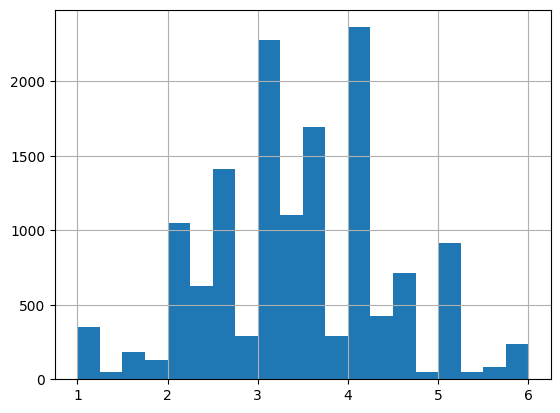

In [20]:
filtered_data['average_rating'] = filtered_data.groupby('file')['rating'].transform('mean')
filtered_data['average_rating'].hist(bins=20)

In [21]:
# example
filtered_data[filtered_data["file"].str.contains("logo_5_")]

,file,animation_id,model_output,label,rating,average_rating
16682,logo_5_animation_0,7,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",NaN,NaN,NaN
16683,logo_5_animation_0,0,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.8...",NaN,NaN,NaN
16684,logo_5_animation_0,5,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",NaN,NaN,NaN
16685,logo_5_animation_1,7,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Bad,3.0,3.000000
16686,logo_5_animation_2,7,"[1, 0, 0, 0, 0, 0, 0.9560342718892494, 0.94782...",Very Bad,2.0,2.000000
16687,logo_5_animation_2,0,"[0, 0, 1, 0, 0, 0, -1.0, -1.0, -1.0, 0.0565513...",Very Bad,2.0,2.000000
16688,logo_5_animation_3,7,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Bad,3.0,3.000000
16689,logo_5_animation_3,0,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.2...",Okay,4.0,3.000000
16690,logo_5_animation_3,4,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Very Bad,2.0,3.000000
16691,logo_5_animation_4,7,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.2...",Good,5.0,3.250000


### Now pick good Animations only
Pick the following animations
- Best per logo (include as many different logos as possible)
- Add all GOOD animations (additionally add as many animations as possible) TODO: Implement later

In [22]:
filtered_data['include'] = 0

In [23]:
# use all animations with an average rating over 3
minimum_rating = 3
temp = filtered_data['average_rating'] > minimum_rating
filtered_data.loc[temp, 'include'] = 1

In [24]:
print(f"{filtered_data['include'].mean() * 100}% of the data is left out")

34.44150072643364% of the data is left out


In [25]:
# go through each logo to find the best animation
for logo in logos:
    # make a data frame that contains all the animations of one logo
    temp = filtered_data[filtered_data["file"].str.contains(logo)]

    best_logo = temp[temp['average_rating'] == temp['average_rating'].max()]
    best_logo = best_logo['file'].unique()
    
    filtered_data.loc[filtered_data['file'].isin(best_logo), 'include'] = 1
    break

In [26]:
print(f"Now {filtered_data['include'].mean() * 100}% of the data is left out")

Now 34.44150072643364% of the data is left out


Note: No additional animations are selected

In [27]:
best_output = filtered_data[filtered_data['include'] == 1].copy()
best_output.drop(columns=['include'], inplace=True, axis=1)

In [28]:
# extract logo
pattern = r'(logo_\d+)'
best_output['filename'] = best_output['file'].str.extract(pattern)

### Numeration to keep order later (corresponds to start-time)

In [29]:
# Create a time_offset column filled with zeros
best_output['a13'] = 0.0

# Define animation start time offset in seconds from animation start
TIME_OFFSET_STEP = 0.25

# Initialize a dictionary to store numbering for each file
file_counts = {}

# Iterate through the "file" column and number each unique file
for index, row in best_output.iterrows():
    filename = row['file']
    if filename not in file_counts:
        file_counts[filename] = 1
    else:
        file_counts[filename] += 1
    best_output.at[index, 'a13'] = file_counts[filename] * TIME_OFFSET_STEP
best_output.head()

,file,animation_id,model_output,label,rating,average_rating,filename,a13
0,logo_316_animation_0,4,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.8...",Good,5.0,5.000000,logo_316,0.25
1,logo_316_animation_0,24,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0,5.000000,logo_316,0.50
2,logo_316_animation_0,23,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0,5.000000,logo_316,0.75
3,logo_316_animation_1,4,"[1, 0, 0, 0, 0, 0, 0.13436424411240122, 0.8474...",Very Bad,2.0,3.333333,logo_316,0.25
4,logo_316_animation_1,24,"[0, 0, 1, 0, 0, 0, -1.0, -1.0, -1.0, 0.7637746...",Okay,4.0,3.333333,logo_316,0.50


### Stat: Animated paths per logo

In [30]:
used_paths = best_output[["filename", "animation_id"]].drop_duplicates(
    subset = ['filename', 'animation_id'], keep = 'last').reset_index(drop = True)
used_paths.head()

,filename,animation_id
0,logo_316,5
1,logo_316,4
2,logo_316,2
3,logo_316,1
4,logo_316,24


array([[<AxesSubplot:title={'center':'animation_id'}>]], dtype=object)

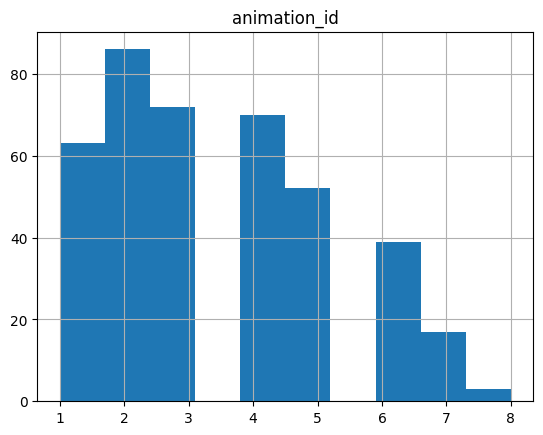

In [31]:
used_paths.groupby(['filename']).count().hist()

### Some Statistics again


In [32]:
grouped = best_output.groupby('file').count()
grouped = grouped[['animation_id']]
print(f"{grouped.size} Animations left over")
histogram_table = grouped['animation_id'].value_counts().reset_index()
histogram_table.columns = ['Animation Length', 'Count']
histogram_table = histogram_table.sort_values(by='Animation Length')
print(histogram_table)

3456 Animations left over
   Animation Length  Count
1                 1   1018
0                 2   1117
2                 3    833
3                 4    283
4                 5     95
5                 6     71
6                 7     36
7                 8      3


# Build sequences

## Make List of all Data Samples

### Apply Stats

In [33]:
final_animation_stats = best_output[['filename', 'file', 'model_output']].copy()
final_animation_stats['animation_length'] = 1
for i in range(6):
 final_animation_stats[f'a{i+1}'] = final_animation_stats['model_output'].apply(lambda x: x[i])
final_animation_stats.drop(['model_output'], inplace=True, axis=1)
final_animation_stats

,filename,file,animation_length,a1,a2,a3,a4,a5,a6
0,logo_316,logo_316_animation_0,1,0,0,0,1,0,0
1,logo_316,logo_316_animation_0,1,0,0,0,0,0,1
2,logo_316,logo_316_animation_0,1,0,0,0,0,1,0
3,logo_316,logo_316_animation_1,1,1,0,0,0,0,0
4,logo_316,logo_316_animation_1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
23372,logo_91,logo_91_animation_8,1,0,0,0,1,0,0
23378,logo_91,logo_91_animation_12,1,0,0,0,0,1,0
23379,logo_91,logo_91_animation_12,1,0,0,0,1,0,0
23380,logo_91,logo_91_animation_13,1,0,1,0,0,0,0


### Group by logo & animation

In [34]:
final_animations_index = final_animation_stats.groupby(['filename', 'file']).sum()
final_animations_index['a0'] = 1 # EOS one per animation sequence
final_animations_index = final_animations_index.reset_index()
final_animations_index

,filename,file,animation_length,a1,a2,a3,a4,a5,a6,a0
0,logo_0,logo_0_animation_0,5,0,0,1,1,2,1,1
1,logo_0,logo_0_animation_13,5,0,1,1,0,2,1,1
2,logo_0,logo_0_animation_14,4,1,1,0,1,1,0,1
3,logo_0,logo_0_animation_15,2,0,2,0,0,0,0,1
4,logo_0,logo_0_animation_4,6,1,1,0,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...
3451,logo_99,logo_99_animation_4,3,0,1,0,1,1,0,1
3452,logo_99,logo_99_animation_5,3,0,0,0,1,0,2,1
3453,logo_99,logo_99_animation_6,3,1,1,0,1,0,0,1
3454,logo_99,logo_99_animation_7,3,0,0,0,1,2,0,1


### Balance and Oversampling

In [35]:
final_animations_index['repeat'] = 1

def print_balancing_stats(df: pd.DataFrame, silent=False):
    temp = df.copy()
    temp = temp[~temp['filename'].isin(logos_test)] # train data only
    temp = temp.reset_index().drop(['filename', 'file','animation_length'], axis=1)
    for i in range(0, 7):
        temp[f'a{i}'] = temp[f'a{i}'] * temp['repeat']
    balance = temp[['a1', 'a2', 'a3', 'a4', 'a5', 'a6']].sum()
    balance_percentage = min(balance) / max(balance)
    balance_diff = max(balance) - min(balance)
    if silent:
        return balance_diff, balance_percentage, balance.nsmallest(6).index
    print(f"Balanced with oversampling {int(temp['repeat'].sum() / len(temp) * 100)-100}% to {int(balance_percentage * 100)}%")
    print(balance)
    
print_balancing_stats(final_animations_index)

Balanced with oversampling 0% to 40%
a1     877
a2    1001
a3     633
a4    1244
a5    1551
a6    1163
dtype: int64


In [36]:
print_balancing_stats(final_animations_index, silent=True)

(918,
 0.4081237911025145,
 Index(['a3', 'a1', 'a2', 'a6', 'a4', 'a5'], dtype='object'))

Currently, EOS (a0) occurs much more often then the other animation types.

Let's oversample all sequences > 1

In [37]:
final_animations_index[final_animations_index['filename'] == 'logo_2']

,filename,file,animation_length,a1,a2,a3,a4,a5,a6,a0,repeat
860,logo_2,logo_2_animation_0,3,0,0,0,1,1,1,1,1
861,logo_2,logo_2_animation_1,1,0,0,0,0,1,0,1,1
862,logo_2,logo_2_animation_14,4,1,1,0,1,1,0,1,1
863,logo_2,logo_2_animation_15,2,0,2,0,0,0,0,1,1
864,logo_2,logo_2_animation_3,2,0,0,0,0,1,1,1,1
865,logo_2,logo_2_animation_4,4,1,0,1,1,1,0,1,1
866,logo_2,logo_2_animation_8,3,0,0,0,2,0,1,1,1
867,logo_2,logo_2_animation_9,2,0,1,1,0,0,0,1,1


Through oversampling, this can be optimized...

In [38]:
# Very fancy sampling
def get_filter_mask(df, rare_animations, second_rarest=False, second_most_frequent=False, max_repetition=8):
    if second_rarest and second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      (df[rare_animations[1]] > 0) &
                      (df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    if second_rarest and not second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      #(df[rare_animations[1]] > 0) &
                      (df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    if not second_rarest and second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      (df[rare_animations[1]] > 0) &
                      #(df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    return df.loc[(df[rare_animations[0]] > 0) & 
                  #(df[rare_animations[1]] > 0) &
                  #(df[rare_animations[4]] == 0) &
                  (df[rare_animations[5]] == 0) &
                  (df['repeat'] < df['animation_length'] + 2) &
                  (df['repeat'] < max_repetition)]

final_animations_index['repeat'] = 1
sample_size = 5

for i in range(1000):
    balance_diff, balance, rare_animations = print_balancing_stats(final_animations_index, silent=True)
    if balance_diff < 20:
        sample_size = 1
        filtering = get_filter_mask(final_animations_index, rare_animations, second_most_frequent=True, max_repetition=8)

    else:
        filtering = get_filter_mask(final_animations_index, rare_animations, second_rarest=True, second_most_frequent=True, max_repetition=6)
        if len(filtering == 0):
            filtering = get_filter_mask(final_animations_index, rare_animations, second_most_frequent=True, max_repetition=7)
            if len(filtering == 0):
                filtering = get_filter_mask(final_animations_index, rare_animations, max_repetition=8)
            
    if balance_diff < 20:
        print(f"Final oversampling: {balance_diff} difference, {len(filtering)} in filtering")
    if balance_diff < 2:
        print(f"Break after {i} Iterations")
        break

    random_indices = filtering.sample(n=min(sample_size, len(filtering))).index.tolist()
    final_animations_index.loc[random_indices, 'repeat'] += 1
    
print_balancing_stats(final_animations_index)

Final oversampling: 16 difference, 77 in filtering
Final oversampling: 16 difference, 77 in filtering
Final oversampling: 16 difference, 76 in filtering
Final oversampling: 15 difference, 75 in filtering
Final oversampling: 14 difference, 160 in filtering
Final oversampling: 12 difference, 86 in filtering
Final oversampling: 11 difference, 76 in filtering
Final oversampling: 11 difference, 75 in filtering
Final oversampling: 11 difference, 136 in filtering
Final oversampling: 11 difference, 136 in filtering
Final oversampling: 10 difference, 75 in filtering
Final oversampling: 10 difference, 74 in filtering
Final oversampling: 12 difference, 160 in filtering
Final oversampling: 11 difference, 159 in filtering
Final oversampling: 11 difference, 74 in filtering
Final oversampling: 10 difference, 136 in filtering
Final oversampling: 9 difference, 132 in filtering
Final oversampling: 8 difference, 74 in filtering
Final oversampling: 9 difference, 187 in filtering
Final oversampling: 9 diff

<AxesSubplot:>

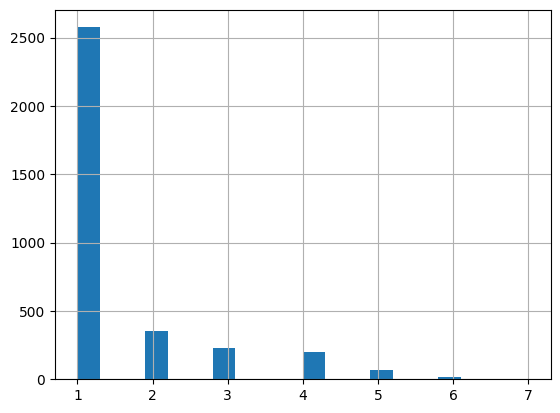

In [39]:
final_animations_index['repeat'].hist(bins=20)

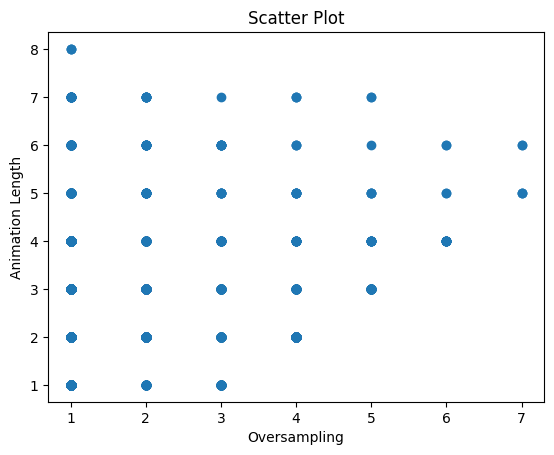

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the two columns for the scatter plot
x = final_animations_index['repeat']
y = final_animations_index['animation_length']

# Create a scatter plot
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('Oversampling')
plt.ylabel('Animation Length')
plt.title('Scatter Plot')

# Show the plot
plt.show()

In [41]:
final_animations_index[final_animations_index['filename'] == 'logo_2']

,filename,file,animation_length,a1,a2,a3,a4,a5,a6,a0,repeat
860,logo_2,logo_2_animation_0,3,0,0,0,1,1,1,1,1
861,logo_2,logo_2_animation_1,1,0,0,0,0,1,0,1,1
862,logo_2,logo_2_animation_14,4,1,1,0,1,1,0,1,1
863,logo_2,logo_2_animation_15,2,0,2,0,0,0,0,1,1
864,logo_2,logo_2_animation_3,2,0,0,0,0,1,1,1,1
865,logo_2,logo_2_animation_4,4,1,0,1,1,1,0,1,1
866,logo_2,logo_2_animation_8,3,0,0,0,2,0,1,1,1
867,logo_2,logo_2_animation_9,2,0,1,1,0,0,0,1,4


### Merge logo stats

In [42]:
logos.head()

,filename,count,count_category
0,logo_0,10,Quantile 1
1,logo_1,8,Quantile 0
2,logo_10,10,Quantile 1
3,logo_100,22,Quantile 9
4,logo_101,27,Quantile 14


In [43]:
final_animations_index = final_animations_index.merge(logos[["filename","count"]], on='filename', how='left')
final_animations_index.rename(columns={'count': 'num_paths'}, inplace=True)
final_animations_index

,filename,file,animation_length,a1,a2,a3,a4,a5,a6,a0,repeat,num_paths
0,logo_0,logo_0_animation_0,5,0,0,1,1,2,1,1,1,10
1,logo_0,logo_0_animation_13,5,0,1,1,0,2,1,1,1,10
2,logo_0,logo_0_animation_14,4,1,1,0,1,1,0,1,1,10
3,logo_0,logo_0_animation_15,2,0,2,0,0,0,0,1,1,10
4,logo_0,logo_0_animation_4,6,1,1,0,1,2,1,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...
3451,logo_99,logo_99_animation_4,3,0,1,0,1,1,0,1,1,24
3452,logo_99,logo_99_animation_5,3,0,0,0,1,0,2,1,1,24
3453,logo_99,logo_99_animation_6,3,1,1,0,1,0,0,1,3,24
3454,logo_99,logo_99_animation_7,3,0,0,0,1,2,0,1,1,24


### Plot: Number of Paths vs Animation Length

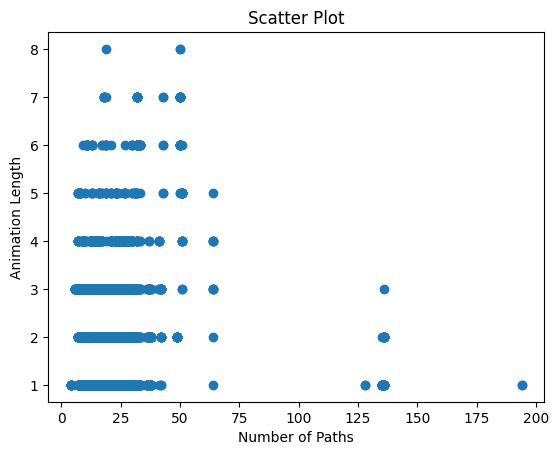

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the two columns for the scatter plot
x = final_animations_index['num_paths']
y = final_animations_index['animation_length']

# Create a scatter plot
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('Number of Paths')
plt.ylabel('Animation Length')
plt.title('Scatter Plot')

# Show the plot
plt.show()

## Bucketing
For batching the data later on, build buckets to group animations with similar length characteristics

In [45]:
# from dataset_helper import generate_buckets_2D
# generate_buckets_2D(final_animations_index,
#                  'count',
#                  'animation_length',
#                  [0.2, 0.4, 0.6, 0.8, 1],
#                  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Build Input Sequences Dictionary

In [46]:
def build_input_sequences_dict(sequences: pd.DataFrame, used_paths: pd.DataFrame, is_used_path_filtering = False, keep_unused=False):
    initial_length = len(sequences)
    used_paths['animation_id'] = used_paths['animation_id'].astype(str)
    
    if is_used_path_filtering:
        if keep_unused:
            # If keeping unused paths, perform a left merge and then filter where used paths are NaN
            sequences = pd.merge(sequences, used_paths, on=['filename', 'animation_id'], how='left', indicator=True)
            sequences = sequences[sequences['_merge'] == 'left_only'].drop(columns=['_merge']).copy()
            print(f"Filtering of input sequences to keep only unused paths. Reduction from {initial_length} to {len(sequences)} paths.")
        else:
            # If not keeping unused paths, perform an inner merge to keep only used paths
            sequences = pd.merge(sequences, used_paths, on=['filename', 'animation_id']).copy()
            print(f"Filtering of input sequences on only used paths. Reduction from {initial_length} to {len(sequences)} paths.")

    dict = {}
    for logo in sequences["filename"].unique():
        dict[logo] = sequences[sequences["filename"]==logo]
    
    return dict

In [47]:
input_sequences_dict_used = build_input_sequences_dict(input_sequences, used_paths, is_used_path_filtering=True)
input_sequences_dict_used[logos_train[0]]

Filtering of input sequences on only used paths. Reduction from 10809 to 1368 paths.


,filename,animation_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
1203,logo_58,0,0.004191,0.171633,-0.018381,0.748444,-1.044739,0.953102,0.540252,-0.270049,...,-0.098905,-2.787906,-1.285430,1.339247,0.996667,-1.182158,-1.182036,0.043877,1.519992,0.518400
1204,logo_58,6,0.293771,-1.439355,1.039430,-0.695287,-0.298533,-0.400185,-1.761774,-0.891614,...,-3.054226,-3.460104,0.292588,0.068690,0.486753,-1.571588,-1.116157,0.483256,-0.600954,0.783962
1205,logo_58,4,0.284717,-0.542166,1.165785,-0.165110,-0.862798,-0.240304,-1.127283,-0.600646,...,-1.999305,-3.452564,-0.160504,0.304545,0.521432,-1.635403,-1.385547,-0.008391,0.349376,1.075091
1207,logo_58,9,0.715510,-1.223370,1.123417,1.002407,0.163753,1.648535,-0.112014,-0.639295,...,0.802521,-0.508118,-0.696729,1.346594,0.019541,-0.485907,-0.585498,-0.670413,0.892107,-0.760658


In [48]:
input_sequences_dict_unused = build_input_sequences_dict(input_sequences, used_paths, is_used_path_filtering=True, keep_unused=True)
input_sequences_dict_unused[logos_train[0]]

Filtering of input sequences to keep only unused paths. Reduction from 10809 to 9441 paths.


,filename,animation_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
9584,logo_58,2,0.284849,-1.443481,0.894656,0.288777,-0.119204,0.597970,-1.347018,-0.562408,...,-1.509393,-3.375059,-0.417338,2.140346,1.284125,-1.140110,-1.019368,-0.478531,0.627703,0.787182
9585,logo_58,1,0.260487,-1.116527,0.785492,0.563341,-0.210848,0.852614,-0.864086,-0.417955,...,-0.799908,-2.934812,-0.615855,2.294054,1.309447,-0.943090,-0.945063,-0.582304,1.024145,0.667737
9588,logo_58,3,0.413931,-1.237834,0.630103,0.121826,-0.473777,0.910343,-1.188808,-0.649567,...,-1.292685,-3.524250,-0.731151,1.370453,1.139083,-1.346588,-1.435273,0.146662,0.247259,0.509319
9591,logo_58,5,0.520413,-2.291315,0.954445,-0.354854,0.457764,0.122510,-2.555781,-0.980532,...,-3.028167,-3.422288,0.270729,1.153242,1.133680,-1.124239,-1.019923,0.369897,-0.859145,0.708799
9592,logo_58,7,0.274295,-2.314953,0.837563,-0.132603,0.673548,-0.018834,-1.767771,-1.240576,...,-2.335364,-2.583277,0.259264,0.280770,0.304752,-1.219665,-0.217151,0.777639,-1.568387,0.225487
9593,logo_58,8,0.024264,-1.966241,1.267918,-0.530434,0.357375,-1.048408,-2.659886,-0.793704,...,-3.687108,-2.785984,0.456188,-0.294962,0.475424,-1.198858,-0.767279,0.671654,-0.935195,1.098485


## Build Output Sequence (Embedded Paths with Animation Vector)

In [49]:
# Merge Dataframes
output_sequence = pd.merge(best_output, embeddings, on=['filename', 'animation_id'], how='inner')
animation_vectors = pd.DataFrame(output_sequence["model_output"].to_list(), columns=["a1","a2","a3","a4","a5","a6","a7","a8","a9","a10","a11","a12"])
output_sequence.drop(['animation_id', 'model_output', 'label', 'rating', 'average_rating'], inplace=True, axis=1)
output_sequence['a0'] = 0 # EOS Feature in One-hot Encoding
output_sequence = pd.merge(output_sequence, animation_vectors, left_index=True, right_index=True)

In [50]:
# Move column 'a13' to the back
column_to_move = 'a13'
new_order = [col for col in output_sequence.columns if col != column_to_move]
new_order.append(column_to_move)
output_sequence = output_sequence[new_order]

In [51]:
output_sequence.head()

,file,filename,0,1,2,3,4,5,6,7,...,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13
0,logo_316_animation_0,logo_316,-0.611078,0.325208,-0.712887,3.094918,-0.679966,1.275185,0.480179,-0.602657,...,1,0,0,-1.000000,-1.000000,-1.0,-1.000000,0.844422,0.757954,0.25
1,logo_316_animation_1,logo_316,-0.611078,0.325208,-0.712887,3.094918,-0.679966,1.275185,0.480179,-0.602657,...,0,0,0,0.134364,0.847434,-1.0,-1.000000,-1.000000,-1.000000,0.25
2,logo_316_animation_4,logo_316,-0.611078,0.325208,-0.712887,3.094918,-0.679966,1.275185,0.480179,-0.602657,...,0,1,0,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,0.50
3,logo_316_animation_7,logo_316,-0.611078,0.325208,-0.712887,3.094918,-0.679966,1.275185,0.480179,-0.602657,...,0,0,0,-1.000000,-1.000000,-1.0,0.323833,-1.000000,-1.000000,0.25
4,logo_316_animation_8,logo_316,-0.611078,0.325208,-0.712887,3.094918,-0.679966,1.275185,0.480179,-0.602657,...,1,0,0,-1.000000,-1.000000,-1.0,-1.000000,0.226706,0.962295,0.50


## Main Iteration over all samples

In [52]:
from dataset_helper import generate_dataset

dataset = generate_dataset(final_animations_index,
                           input_sequences_dict_used,
                           input_sequences_dict_unused,
                           output_sequence,
                           {"train": logos_train, "test": logos_test},
                           sequence_length_input=8, # low as filtered
                           sequence_length_output=10, # input + SOS / EOS
                           )
# Executed in 1 minute with shortened padding ~Cornelius

TypeError: 'type' object is not subscriptable

## Result

In [ ]:
torch.save(dataset["train"]["input"], 'data/prototype_dataset/train_sequence_input.pt')
torch.save(dataset["train"]["output"], 'data/prototype_dataset/train_sequence_output.pt')
torch.save(dataset["test"]["input"], 'data/prototype_dataset/test_sequence_input.pt')
torch.save(dataset["test"]["output"], 'data/prototype_dataset/test_sequence_output.pt')

In [ ]:
print(dataset["train"]["input"].size())
print(dataset["train"]["output"].size())
print(dataset["test"]["input"].size())
print(dataset["test"]["output"].size())